# Введение в нейронные сети

## Эпизод 2b: Многослойный персептрон на PyTorch

Дмитрий Сошников | dmitri@soshnikov.com

http://github.com/shwars/NeuroWorkshop
-> Notebooks -> IntroPyTorch.ipynb

## Нейросетевые фреймворки

Мы видели, что для обучения нейросетей нужно:
* Быстро умножать матрицы (тензоры)
* Считать производные для вычисления градиента для метода обратного распространения ошибки

Что позволяют делать нейросетевые фреймворки:
* Оперировать с тензорами, как на CPU, так и на GPU
* Автоматически вычислять производные (они вручную прописаны для всех элементарных функций)

Опционально:
* Конструктор для нейросетей (описание сети как набора слоёв)
* Простые функции для обучения (`fit`, как в Scikit Learn)
* Набор алгоритмов оптимизации
* Набор абстракций для работы с данными

## Основные фреймворки

* Tensorflow 1.0 - первый, получивший широкое распространение (Google). Позволял определять статический computation graph, и затем в явном виде выполнять вычисления
* PyTorch - Facebook
* Keras - надстройка над Tensorflow/PyTorch для унификации (Francois Chollet)
* Tensorflow 2.0 + Keras - динамический вычислительный граф, код получается похожим на обычные вычисления в numpy

Мы рассмотрим PyTorch. Для начала рекомендуется установить PyTorch [по инструкции на сайте](https://pytorch.org/get-started/locally/). Либо можно выполнять код в [Google Colab](https://colab.research.google.com/), в котором PyTorch уже установлен.

In [168]:
import torch
torch.__version__

'1.8.0+cu101'

## Основные понятия в PyTorch

**Тензор** - это многомерный массив произвольной размерности. Удобно использовать при обучении нейросетей, например:
* 400x400 - чёрно-белая картинка
* 400x400x3 - цветная картинка
* 16x400x400x3 - minibatch из 16 картинок, используемый для одного шага обучения
* 25x400x400x3 - секунда видео
* 8x25x400x400x3 - minibatch из 8 1-секундных видео

### Простые тензоры

In [169]:
a = torch.tensor([[1,2],[3,4]])
print(a)
a = torch.randn(size=(10,3))
print(a)

tensor([[1, 2],
        [3, 4]])
tensor([[ 0.1288, -0.8088, -0.2092],
        [ 0.0789, -1.4706, -0.8880],
        [-0.0601,  0.6659, -3.2120],
        [ 0.8023, -0.4045, -1.0164],
        [-1.5578, -1.3014, -0.8372],
        [ 1.3626, -1.0825, -2.7018],
        [ 0.2258, -0.7675, -0.4102],
        [-1.9663,  0.0386, -2.6183],
        [ 0.7666, -1.3057, -0.4486],
        [-0.9006,  0.7092,  0.8018]])


С тензорами можно производить обычные вычисления, которые производятся поэлементно (как в numpy). При этом тензоры автоматически дополняются до нужной размерности. Можно извлечь numpy-массив из тензора при помощи `.numpy()`:

In [170]:
print(a-a[0])
print(torch.exp(a)[0].numpy())

tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0499, -0.6618, -0.6788],
        [-0.1889,  1.4747, -3.0028],
        [ 0.6734,  0.4044, -0.8072],
        [-1.6867, -0.4926, -0.6280],
        [ 1.2338, -0.2737, -2.4927],
        [ 0.0970,  0.0413, -0.2010],
        [-2.0951,  0.8475, -2.4091],
        [ 0.6377, -0.4969, -0.2395],
        [-1.0295,  1.5180,  1.0110]])
[1.1375165  0.44538715 0.81125516]


## In-place и out-of-place операции

Обычно операции с тензорами возвращают новые тензоры. Однако для большинства операций сущетвуют аналогичные варианты, которые модифицируют исходный тензор:

In [171]:
u = torch.tensor(5)
print("Result when adding out-of-place:",u.add(torch.tensor(3)))
u.add_(torch.tensor(3))
print("Result after adding in-place:", u)

Result when adding out-of-place: tensor(8)
Result after adding in-place: tensor(8)


Например, вот там можно "наивно" посчитать сумму строк тензора `a`:

In [172]:
s = torch.zeros_like(a[0])
for i in a:
  s.add_(i)

print(s)

tensor([ -1.1197,  -5.7273, -11.5398])


Умный способ:

In [176]:
torch.sum(a,axis=0)

tensor([ -1.1197,  -5.7273, -11.5398])

Подробнее про тензоры в PyTorch смотрите [в официальном руководстве](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

## Вычисляем производные

Для обратного распространения ошибки, нам нужно уметь вычислять градиенты. Мы можем пометить любой тензор в PyTorch атрибутом `requires_grad`, и впоследствии автоматически будут вычисляться все градиенты при операциях с этим тензором. Для вычисления производной необходимо вызвать метод `backward()`:


In [179]:
a = torch.randn(size=(2, 2), requires_grad=True)
b = torch.randn(size=(2, 2))

c = torch.mean(torch.sqrt(torch.square(a) + torch.square(b)))  # Do some math using `a`
c.backward() # call backward() to compute all gradients
# What's the gradient of `c` with respect to `a`?
print(a.grad)

tensor([[0.0227, 0.1661],
        [0.1980, 0.2253]])


На самом деле, PyTorch может таким образом вычислять "накапливаемые" градиенты. Если при вызове `backward` указать `retain_graph=True`, то граф вычислений будет сохраняться, и градиенты - накапливаться. Чтобы начать их вычислять заново, нужно в явном виде обнулить поле `grad`:  

In [180]:
c = torch.mean(torch.sqrt(torch.square(a) + torch.square(b)))
c.backward(retain_graph=True)
c.backward(retain_graph=True)
print(a.grad)
a.grad.zero_()
c.backward()
print(a.grad)

tensor([[0.0681, 0.4983],
        [0.5939, 0.6758]])
tensor([[0.0227, 0.1661],
        [0.1980, 0.2253]])


Для вычисления градиентов PyTorch создаёт и поддерживает **граф вычислений**. Для каждого тензора, который вычисляется с использованием тензоров с установленным флагом `requires_grad`, устанавливается специальная функция `grad_fn`, представляющая собой функцию для вычисления производной по правилу дифференциирования сложной функции:

In [181]:
print(c)

tensor(1.0358, grad_fn=<MeanBackward0>)


На самом деле, PyTorch может вычислять градиенты только для скалярных функций. Если речь идет о вычислении производной тензора по тензору, то PyTorch позволяет нам вычислять произведение якобиана на вектор.

Например, пусть есть векторная функция $\vec{y}=f(\vec{x})$, где
$\vec{x}=\langle x_1,\dots,x_n\rangle$ и
$\vec{y}=\langle y_1,\dots,y_m\rangle$, тогда градиент $\vec{y}$ по $\vec{x}$ задаётся **якобианом**:

$$
\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{array}\right)\end{align}
$$

Вместо вычисления якобиана, PyTorch вычисляет произведение $v^T\cdot J$ на некоторый вектор
$v=(v_1 \dots v_m)$. Для этого необходимо вызвать ``backward``, передав `v` в качестве аргумента. Размер `v` должен совпадать с размером исходного тензора, по которому мы вычисляем производную.


In [182]:
c = torch.sqrt(torch.square(a) + torch.square(b))
c.backward(torch.eye(2))
print(a.grad)

tensor([[0.1135, 0.1661],
        [0.1980, 1.1263]])


Подробнее про вычисление градиентов в PyTorch читайте [в официальном руководстве](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

# Пример 0: Оптимизация функции методом градиентного спуска

Попробуем использовать автоматическое дифференциирования для оптимизации простой функции двух переменных $f(x_1,x_2)=(x_1-3)^2+(x_2+2)^2$. Пусть тензор `x` представляет собой текущие координато точки. Мы начнем с некоторой начальной точки $x^{(0)}=(0,0)$, и будет вычислять следующую точку по формуле:
$$
x^{(n+1)} = x^{(n)} - \eta\nabla f
$$
Здесь $\eta$ - т.н. **learning rage** (назоём его `lr` в коде), а $\nabla f = (\frac{\partial f}{\partial x_1},\frac{\partial f}{\partial x_2})$ - градиент функции $f$.

Для начала определим стартовое значение `x` и функцию `f`:

In [184]:
x = torch.zeros(2,requires_grad=True)
f = lambda x : (x-torch.tensor([3,-2])).pow(2).sum()
lr = 0.1

Теперь проделаем 15 итераций градиентного спуска. На каждой итерации, мы будем обновлять координаты `x` и печатать их, чтобы убедиться, что мы достигаем минимума (3,-2):

In [186]:
for i in range(15):
    y = f(x)
    y.backward()
    gr = x.grad
    x.data.add_(-lr*gr)
    x.grad.zero_()
    print("Step {}: x[0]={}, x[1]={}".format(i,x[0],x[1]))

Step 0: x[0]=1.2000000476837158, x[1]=-0.800000011920929
Step 1: x[0]=1.5600000619888306, x[1]=-1.0399999618530273
Step 2: x[0]=1.8480000495910645, x[1]=-1.2319999933242798
Step 3: x[0]=2.078400135040283, x[1]=-1.385599970817566
Step 4: x[0]=2.2627201080322266, x[1]=-1.5084799528121948
Step 5: x[0]=2.4101760387420654, x[1]=-1.6067839860916138
Step 6: x[0]=2.5281407833099365, x[1]=-1.685427188873291
Step 7: x[0]=2.6225125789642334, x[1]=-1.7483417987823486
Step 8: x[0]=2.698009967803955, x[1]=-1.798673391342163
Step 9: x[0]=2.7584080696105957, x[1]=-1.8389387130737305
Step 10: x[0]=2.8067264556884766, x[1]=-1.8711509704589844
Step 11: x[0]=2.845381259918213, x[1]=-1.8969208002090454
Step 12: x[0]=2.876305103302002, x[1]=-1.9175366163253784
Step 13: x[0]=2.9010441303253174, x[1]=-1.9340293407440186
Step 14: x[0]=2.920835256576538, x[1]=-1.947223424911499


## Пример 1: Линейная регрессия

Попробуем с помощью полученных знаний решить классическую задачу линейной регрессии. Для этого сгенерируем небольшой синтетический датасет:

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random

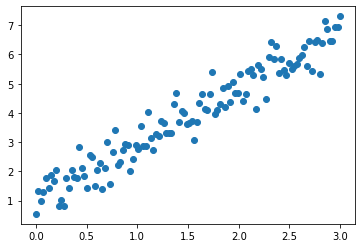

In [188]:
np.random.seed(13) # pick the seed for reproducability - change it to explore the effects of random variations

train_x = np.linspace(0, 3, 120)
train_labels = 2 * train_x + 0.9 + np.random.randn(*train_x.shape) * 0.5

plt.scatter(train_x,train_labels)

Линейная регрессия вычисляется как $f_{W,b}(x) = Wx+b$, где $W, b$ - параметры модели, которые необходимо найти. Функция ошибки на наборе данных $\{x_i,y_u\}_{i=1}^N$ может быть определена как среднеевадратичное отклонение
$$
\mathcal{L}(W,b) = {1\over N}\sum_{i=1}^N (f_{W,b}(x_i)-y_i)^2
$$

Опишем модель и функцию ошибки:

In [189]:
input_dim = 1
output_dim = 1
learning_rate = 0.1

# This is our weight matrix
w = torch.tensor([100.0],requires_grad=True,dtype=torch.float32)
# This is our bias vector
b = torch.zeros(size=(output_dim,),requires_grad=True)

def f(x):
  return torch.matmul(x,w) + b

def compute_loss(labels, predictions):
  return torch.mean(torch.square(labels - predictions))

Обучать модель будем на сериях примеров - minibatches. Для обучения используем градиентный спуск, подстраивая парметры в соответствии с формулой:
$$
\begin{array}{l}
W^{(n+1)}=W^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial W} \\
b^{(n+1)}=b^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial b} \\
\end{array}
$$

In [190]:
def train_on_batch(x, y):
  predictions = f(x)
  loss = compute_loss(y, predictions)
  loss.backward()
  w.data.sub_(learning_rate * w.grad)
  b.data.sub_(learning_rate * b.grad)
  w.grad.zero_()
  b.grad.zero_()
  return loss

Теперь приступаем к обучению: делаем несколько проходов по всему датасету (эпох), разбиваем его на minibatches, и вызываем функцию обучения:

In [191]:
# Shuffle the data.
indices = np.random.permutation(len(train_x))
features = torch.tensor(train_x[indices],dtype=torch.float32)
labels = torch.tensor(train_labels[indices],dtype=torch.float32)

In [192]:
batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    loss = train_on_batch(features[i:i+batch_size].view(-1,1),labels[i:i+batch_size])
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 94.5247
Epoch 1: last batch loss = 9.3428
Epoch 2: last batch loss = 1.4166
Epoch 3: last batch loss = 0.5224
Epoch 4: last batch loss = 0.3807
Epoch 5: last batch loss = 0.3495
Epoch 6: last batch loss = 0.3413
Epoch 7: last batch loss = 0.3390
Epoch 8: last batch loss = 0.3384
Epoch 9: last batch loss = 0.3382


In [193]:
w,b

(tensor([1.8617], requires_grad=True), tensor([1.0711], requires_grad=True))

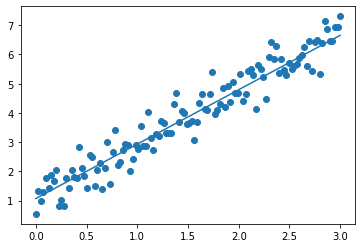

In [194]:
plt.scatter(train_x,train_labels)
x = np.array([min(train_x),max(train_x)])
with torch.no_grad():
  y = w.numpy()*x+b.numpy()
plt.plot(x,y)

## Вычислиения на GPU

Для проведения вычислений на GPU PyTorch поддерживает перемещение тензоров на GPU и автоматическое построение вычислетельного графа там. Традиционный способ вычислений состоит в том, что вначале мы определяем доступное вычислительное устройство `device` (CPU или GPU), и затем перемещаем туда все необходимые тензоры по мере необходимости с помощью вызова `.to(device)`. Мы также можем заранее создавать тензоры на нужно устройстве, указывая параметр `device=...`. Такой код работает без изменений как на GPU, так и на CPU: 

In [195]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on '+device)

### Changes here: indicate device
w = torch.tensor([100.0],requires_grad=True,dtype=torch.float32,device=device)
b = torch.zeros(size=(output_dim,),requires_grad=True,device=device)

def f(x):
  return torch.matmul(x,w) + b

def compute_loss(labels, predictions):
  return torch.mean(torch.square(labels - predictions))

def train_on_batch(x, y):
  predictions = f(x)
  loss = compute_loss(y, predictions)
  loss.backward()
  w.data.sub_(learning_rate * w.grad)
  b.data.sub_(learning_rate * b.grad)
  w.grad.zero_()
  b.grad.zero_()
  return loss

batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    ### Changes here: move data to required device
    loss = train_on_batch(features[i:i+batch_size].view(-1,1).to(device),labels[i:i+batch_size].to(device))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Doing computations on cuda
Epoch 0: last batch loss = 94.5247
Epoch 1: last batch loss = 9.3428
Epoch 2: last batch loss = 1.4166
Epoch 3: last batch loss = 0.5224
Epoch 4: last batch loss = 0.3807
Epoch 5: last batch loss = 0.3495
Epoch 6: last batch loss = 0.3413
Epoch 7: last batch loss = 0.3390
Epoch 8: last batch loss = 0.3384
Epoch 9: last batch loss = 0.3382


## Пример 2: Задача классификации

Рассмотрим пример двухмерной задачи классификации на 2 класса. Примером такой задачи может быть классификация опухоли на 2 типа - доброкачественная и злокачественная, в зависимости от её размера и возраста.

Сгенерируем тестовые данные случайным образом:


In [196]:
np.random.seed(0) # pick the seed for reproducability - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2,class_sep=1)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100, (15+70)*n//100 ]
train_x, valid_x, test_x = np.split(X, split)
train_labels, valid_labels, test_labels = np.split(Y, split)

In [197]:
def plot_dataset(features, labels, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    fig.show()

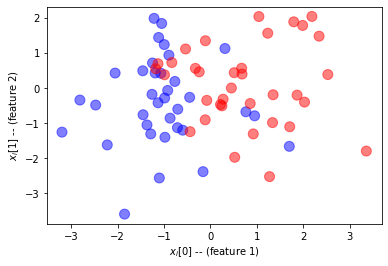

In [198]:
plot_dataset(train_x, train_labels)

## Обучение простейшего одноуровневого персептрона вручную

Используем возможности tensorflow по вычислению градиента для обучения одноуровневого персептрона.

Для начала, задаём архитектуру сети, в которой будет 2 входа и один выход. Соответственно, матрица весов $W$ будет иметь размерность $2\times1$, а вектор сдвига $b$ -- $1$.

Для удобства сгруппируем все параметры в отдельный класс:


In [199]:
class Network():
  def __init__(self):
     self.W = torch.randn(size=(2,1),requires_grad=True)
     self.b = torch.zeros(size=(1,),requires_grad=True)

  def forward(self,x):
    return torch.matmul(x,self.W)+self.b

  def zero_grad(self):
    self.W.data.zero_()
    self.b.data.zero_()

  def update(self,lr=0.1):
    self.W.data.sub_(lr*self.W.grad)
    self.b.data.sub_(lr*self.b)

net = Network()

> Обратите внимание, что мы используем `W.data.zero_()` вместо `W.zero_()`. Это делается потому, что к тензору, состояние которого отслеживается через механизм *Autograd*, нельзя обращаться напрямую.

Функция обучение будет такая же, как в прошлом примере, но функция ошибки будет представлять собой логистическую функцию ошибки. Для этого нам нужно получить на выходе сети значение **вероятности** класса 1, т.е. необходимо привести выход сети $z$ к диапазону [0,1] с помощью передаточной функции `sigmoid`: $p=\sigma(z)$.
Далее, если для примера с номером класса $y_i\in\{0,1\}$ был получен выход сети $p_i$, то ошибка вычисляется как $\mathcal{L_i}=-(y_i\log p_i + (1-y_i)log(1-p_i))$. 

В PyTorch оба эти этапа (применение сигмоиды и взятие логистической функции ошибки) делается одним вызовом `binary_cross_entropy_with_logits`. Поскольку мы делаем обучение по минибатчам, то необходимо усреднить ошибку по всем компонентам минибатча - это функция `binary_cross_entropy_with_logits` делает сама, возвращая одно число. 

> Следует отметить, что вызов `binary_crossentropy_with_logits` эквивалентен последовательному применению `sigmoid` и `binary_crossentropy`

In [200]:
def train_on_batch(net, x, y):
  z = net.forward(x).flatten()
  loss = torch.nn.functional.binary_cross_entropy_with_logits(input=z,target=y)
  net.zero_grad()
  loss.backward()
  net.update()
  return loss

Для чтения данных воспользуемся встроенными функциями PyTorch по организации датасетов. Концепция датасетов основана на двух понятиях:
* **Dataset** - собественно источник данных, может быть **Iterable** и **Map-style**
* **Dataloader** отвечает за загрузку данных и разбиение на батчи.

В нашем случае мы определяем датасет на основе тензора, и далее разбиваем входные данные на минибатчи по 16 элементов. Каждый минибатч включает в себя два тензора, входные данные (размером 16x2) и выходные (вектор длины 16 целого типа - номер класса).

In [201]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = torch.utils.data.TensorDataset(torch.tensor(train_x),torch.tensor(train_labels,dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

list(dataloader)[0]

[tensor([[ 1.3383, -0.9861],
         [ 0.5128,  0.4330],
         [-0.4474, -0.2681],
         [-0.9866, -0.2869],
         [-1.0694,  0.4172],
         [-0.8694, -0.8607],
         [-0.9894,  0.3734],
         [-0.9951,  1.2320],
         [-1.3667, -1.0529],
         [ 0.5239, -1.9724],
         [-1.2474,  0.7092],
         [ 1.8675, -0.2057],
         [-1.1899,  0.4243],
         [ 0.7644, -0.6796],
         [-2.0532,  0.4223],
         [-0.5973, -1.2011]]),
 tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.])]

Теперь мы можем пройтись по всему датасету и организовать процесс обучения:

In [202]:
for epoch in range(15):
  for (x, y) in dataloader:
    loss = train_on_batch(net,x,y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.6447
Epoch 1: last batch loss = 0.6046
Epoch 2: last batch loss = 0.5817
Epoch 3: last batch loss = 0.5680
Epoch 4: last batch loss = 0.5596
Epoch 5: last batch loss = 0.5542
Epoch 6: last batch loss = 0.5507
Epoch 7: last batch loss = 0.5485
Epoch 8: last batch loss = 0.5470
Epoch 9: last batch loss = 0.5459
Epoch 10: last batch loss = 0.5453
Epoch 11: last batch loss = 0.5448
Epoch 12: last batch loss = 0.5445
Epoch 13: last batch loss = 0.5443
Epoch 14: last batch loss = 0.5442


In [203]:
print(net.W,net.b)

tensor([[1.0563],
        [0.4450]], requires_grad=True) tensor([0.], requires_grad=True)


Для демонстрации того, как сработало обучение, построим граничную прямую $W\times x + b = 0.5$

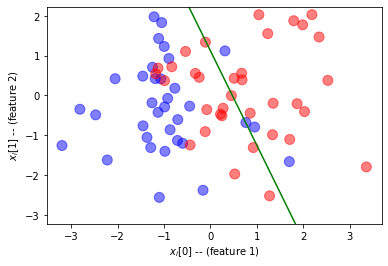

In [204]:
plot_dataset(train_x,train_labels,net.W.detach().numpy(),net.b.detach().numpy())

Посчитаем точность на тестовом датасете:

In [205]:
pred = torch.sigmoid(net.forward(torch.tensor(valid_x)))
torch.mean(((pred.view(-1)>0.5)==(torch.tensor(valid_labels)>0.5)).type(torch.float32))

tensor(0.8667)

## Нейросети и оптимизаторы

В PyTorch реализованы специальные модули `torch.nn.Module` для реализации нейросетей в виде набора слоёв. При этом есть два способа описания нейросетей:
* **Sequential**, в виде перечисления набора слоёв
* В виде **класса**, унаследованного от `Module`

Первый способ проще позволяет описывать стандартные сети, второй - более гибкий, позволяет описывать произвольные сложные конфигурации вычислений.

Внутри модулей можно использовать стандартные слои, среди которых:
* `Linear` - линейный слой, аналогичный нашей нейросети, приведенной выше
* `Softmax`, `Sigmoid`, `ReLU` - слои для передаточных функций

> Обратите внимание, что большинство передаточных функций и функций потерь в PyTorch доступны в двух вариантах: **функциональный** (внутри `torch.nn.functional`) и **в виде класса** (внутри `torch.nn`). Для передаточных функций удобно использовать функции из `torch.nn.functional`, не создавая отдельного слоя.

Для однослойной сети мы можем просто взять экземпляр слоя `Linear`:

In [206]:
net = torch.nn.Linear(2,1) # 2 inputs, 1 output

print(list(net.parameters()))

[Parameter containing:
tensor([[-0.1892, -0.5979]], requires_grad=True), Parameter containing:
tensor([0.1538], requires_grad=True)]


Мы видим, что у сети есть метод `parameters()`, возвращающий все параметры, которые необходимо подстраивать.

Методы обучения, такие, как градиентный спуск, реализованы в виде отдельных объектов, которым передается список параметров:

In [207]:
optim = torch.optim.SGD(net.parameters(),lr=0.05)

С использованием оптимизатора, наш процесс обучения будет выглядеть так:

In [208]:
val_x = torch.tensor(valid_x)
val_lab = torch.tensor(valid_labels)

for ep in range(10):
  for (x,y) in dataloader:
    z = net(x).flatten()
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)
    optim.zero_grad()
    loss.backward()
    optim.step()
  acc = ((torch.sigmoid(net(val_x).flatten())>0.5).float()==val_lab).float().mean()
  print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")

Epoch 0: last batch loss = 1.1270943880081177, val acc = 0.6666666865348816
Epoch 1: last batch loss = 1.0163036584854126, val acc = 0.7333333492279053
Epoch 2: last batch loss = 0.9239333271980286, val acc = 0.800000011920929
Epoch 3: last batch loss = 0.8493780493736267, val acc = 0.9333333373069763
Epoch 4: last batch loss = 0.7907424569129944, val acc = 0.8666666746139526
Epoch 5: last batch loss = 0.7453570365905762, val acc = 0.8666666746139526
Epoch 6: last batch loss = 0.7104158401489258, val acc = 0.8666666746139526
Epoch 7: last batch loss = 0.6834256649017334, val acc = 0.8666666746139526
Epoch 8: last batch loss = 0.6623864769935608, val acc = 0.8666666746139526
Epoch 9: last batch loss = 0.645784318447113, val acc = 0.8666666746139526


> Обратите внимание, что для вызова (применения) нейросети к входному аргументу мы используем синтаксис `net(x)`, вместо `net.forward(x)`, поскольку `nn.Module` реализует метод `__call__()`

С учётом описанного, можем описать универсальную обучающую функцию:

In [214]:
def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.05):
  optim = torch.optim.Adam(net.parameters(),lr=lr)
  for ep in range(epochs):
    for (x,y) in dataloader:
      z = net(x).flatten()
      loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)
      optim.zero_grad()
      loss.backward()
      optim.step()
    acc = ((torch.sigmoid(net(val_x).flatten())>0.5).float()==val_lab).float().mean()
    print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")

net = torch.nn.Linear(2,1)

train(net,dataloader,val_x,val_lab,lr=0.03)

Epoch 0: last batch loss = 0.6797666549682617, val acc = 0.06666667014360428
Epoch 1: last batch loss = 0.6262387037277222, val acc = 0.06666667014360428
Epoch 2: last batch loss = 0.5835054516792297, val acc = 0.20000000298023224
Epoch 3: last batch loss = 0.5517064332962036, val acc = 0.2666666805744171
Epoch 4: last batch loss = 0.5291333794593811, val acc = 0.2666666805744171
Epoch 5: last batch loss = 0.5140607357025146, val acc = 0.3333333432674408
Epoch 6: last batch loss = 0.5050028562545776, val acc = 0.4000000059604645
Epoch 7: last batch loss = 0.5006228089332581, val acc = 0.6000000238418579
Epoch 8: last batch loss = 0.4996645152568817, val acc = 0.6000000238418579
Epoch 9: last batch loss = 0.5009827017784119, val acc = 0.7333333492279053


## Описание сети в виде набора слоёв

Простейшую многослойную нейросеть можно описать в виде набора последовательно-применяемых слоёв. При этом такая сеть будет обладать всеми характеристиками вышеописанных - она автоматически соберёт в методе `parameters` параметры всех промежуточных слоёв

In [215]:
net = torch.nn.Sequential(torch.nn.Linear(2,5),torch.nn.Sigmoid(),torch.nn.Linear(5,1))
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


Обучать такую сеть мы можем с помощью описанного ранее метода `train`:

In [216]:
train(net,dataloader,val_x,val_lab)

Epoch 0: last batch loss = 0.6622872352600098, val acc = 0.6666666865348816
Epoch 1: last batch loss = 0.6727332472801208, val acc = 0.800000011920929
Epoch 2: last batch loss = 0.6326467990875244, val acc = 0.800000011920929
Epoch 3: last batch loss = 0.5876082181930542, val acc = 0.7333333492279053
Epoch 4: last batch loss = 0.5610458254814148, val acc = 0.7333333492279053
Epoch 5: last batch loss = 0.5546905398368835, val acc = 0.7333333492279053
Epoch 6: last batch loss = 0.5626044273376465, val acc = 0.7333333492279053
Epoch 7: last batch loss = 0.5754281878471375, val acc = 0.800000011920929
Epoch 8: last batch loss = 0.5850474238395691, val acc = 0.800000011920929
Epoch 9: last batch loss = 0.5874522924423218, val acc = 0.800000011920929


## Описание нейросети в виде класса

Это более гибкий способ описания нейросетей, поскольку он позволяет выполнять произвольные вычисления.

In [230]:
class MyNet(torch.nn.Module):
  def __init__(self,hidden_size=10,func=torch.nn.Sigmoid()):
    super().__init__()
    self.fc1 = torch.nn.Linear(2,hidden_size)
    self.func = func
    self.fc2 = torch.nn.Linear(hidden_size,1)

  def forward(self,x):
    x = self.fc1(x)
    x = self.func(x)
    x = self.fc2(x)
    return x
  
net = MyNet(func=torch.nn.ReLU())
print(net)

MyNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (func): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [231]:
train(net,dataloader,val_x,val_lab,lr=0.005)

Epoch 0: last batch loss = 0.6930208206176758, val acc = 0.8666666746139526
Epoch 1: last batch loss = 0.6779811382293701, val acc = 0.9333333373069763
Epoch 2: last batch loss = 0.6627538800239563, val acc = 0.9333333373069763
Epoch 3: last batch loss = 0.6472628712654114, val acc = 0.9333333373069763
Epoch 4: last batch loss = 0.6321150660514832, val acc = 0.9333333373069763
Epoch 5: last batch loss = 0.618022620677948, val acc = 0.9333333373069763
Epoch 6: last batch loss = 0.6052160859107971, val acc = 0.9333333373069763
Epoch 7: last batch loss = 0.5925578474998474, val acc = 0.9333333373069763
Epoch 8: last batch loss = 0.5803073048591614, val acc = 0.9333333373069763
Epoch 9: last batch loss = 0.569009006023407, val acc = 0.9333333373069763


**Задание 1**: Постройте графики ошибок на обучающей и тестовой выборке в процессе обучения

**Задание 2**: Попробуйте решить задачу классификации на датасете MNIST с помощью этого кода. Подсказка: используйте `crossentropy_with_logits` в качестве функции ошибки. При этом в первом случае на выход сети необходимо подавать целевые значения в формате *one hot encoding*, а во втором - в виде целочисленного номера класса.

**Задание 3**: 
Используйте PyTorch для обучения классификатора на сети MNIST. При этом:
* Обратите внимание, что в keras заложены типовые датасеты, включая MNIST. Для обращения к нему достаточно пары строчек кода с использованием библиотеки `torchvision` (см, например, [тут](https://pytorch.org/vision/0.8/datasets.html))
* Попробуйте несколько конфигураций сети с несколькими полносвязными слоями, передаточными функциями, и разным количеством нейронов

Какой точности вам удалось достичь?
